In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import print_function

from pprint import pprint as pp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterSampler
from sklearn.decomposition import PCA


from lib import utils
from lib import cols
from lib import rnn_utils
from lib import xgb_utils
from lib import glm_utils

from lib import preprocess

In [3]:
# modify font size
sns.set(font_scale=1.25)

## Preprocessing

In [4]:
ds_sj, ds_iq = preprocess.preprocess()

lib/utils.py:184: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_iq = df_dev_iq[is_train_iq]
lib/utils.py:185: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_valid_iq = df_dev_iq[is_valid_iq]
lib/utils.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_devtest_iq = df_dev_iq[is_devtest_iq]


sj train: 675 lines	 valid: 156 lines	 devtest: 105 lines	 test: 260 lines
iq train: 363 lines	 valid: 104 lines	 devtest: 53 lines	 test: 156 lines
sj valid: 0.19%
iq valid: 0.22%


## Load trained model

In [5]:
## Xgboost
xgb_models = xgb_utils.load_model("20170430-163753_Xgboost")
model_xgb_sj, model_xgb_iq = xgb_models["sj_model"], xgb_models["iq_model"]
col_feats_xgb_sj, col_feats_xgb_iq = xgb_models["sj_feats"], xgb_models["iq_feats"]

## Negative binomial
nb_models = glm_utils.load_model("20170430-151040_NegativeBinomial")
model_nb_sj, model_nb_iq = nb_models["sj_model"], nb_models["iq_model"]
col_feats_nb_sj, col_feats_nb_iq = nb_models["sj_feats"], nb_models["iq_feats"]

## RNN(LSTM)
rnn_models = rnn_utils.load_model("20170430-231817_LSTM")
model_rnn_sj, model_rnn_iq = rnn_models["sj_model"], rnn_models["iq_model"]
col_feats_rnn_sj, col_feats_rnn_iq = rnn_models["sj_feats"], rnn_models["iq_feats"]



## XGB(RMSE_Roll)
models = xgb_utils.load_model("20170504-010211_Xgboost(RMSE_Roll)")
model_xgb_rmse_sj, model_xgb_rmse_iq = models["sj_model"], models["iq_model"]
col_feats_xgb_rmse_sj, col_feats_xgb_rmse_iq = models["sj_feats"], models["iq_feats"]


/home/akiyuki/.pyenv/versions/miniconda2-4.1.11/envs/mle-capstone/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [6]:
ds_sj.df_all["week_start_dt"] = pd.to_datetime(ds_sj.df_all.week_start_date)
ds_iq.df_all["week_start_dt"] = pd.to_datetime(ds_iq.df_all.week_start_date)

df_all_sj = ds_sj.df_all
df_all_iq = ds_iq.df_all

## 

In [7]:
df_all_sj["xgb_pred"] = xgb_utils.create_prediction(model_xgb_sj, df_all_sj, col_feats_xgb_sj)
df_all_sj["nb_pred"] = glm_utils.create_prediction(model_nb_sj, df_all_sj, col_feats_nb_sj)

df_all_sj["rnn_pred"] = rnn_utils.create_prediction(model_rnn_sj, df_all_sj, col_feats_rnn_sj)
df_all_sj["xgb_rmse_pred"] = xgb_utils.create_prediction(model_xgb_rmse_sj, df_all_sj, col_feats_xgb_rmse_sj)

df_all_iq["xgb_pred"] = xgb_utils.create_prediction(model_xgb_iq, df_all_iq, col_feats_xgb_iq)
df_all_iq["nb_pred"] = glm_utils.create_prediction(model_nb_iq, df_all_iq, col_feats_nb_iq)
df_all_iq["rnn_pred"] = rnn_utils.create_prediction(model_rnn_iq, df_all_iq, col_feats_rnn_iq)

In [8]:
col_date = "week_start_dt"

sj_test = "2008-04-29"
sj_valid = "2003-04-23"

iq_test = "2010-07-02"
iq_valid = "2007-06-25"

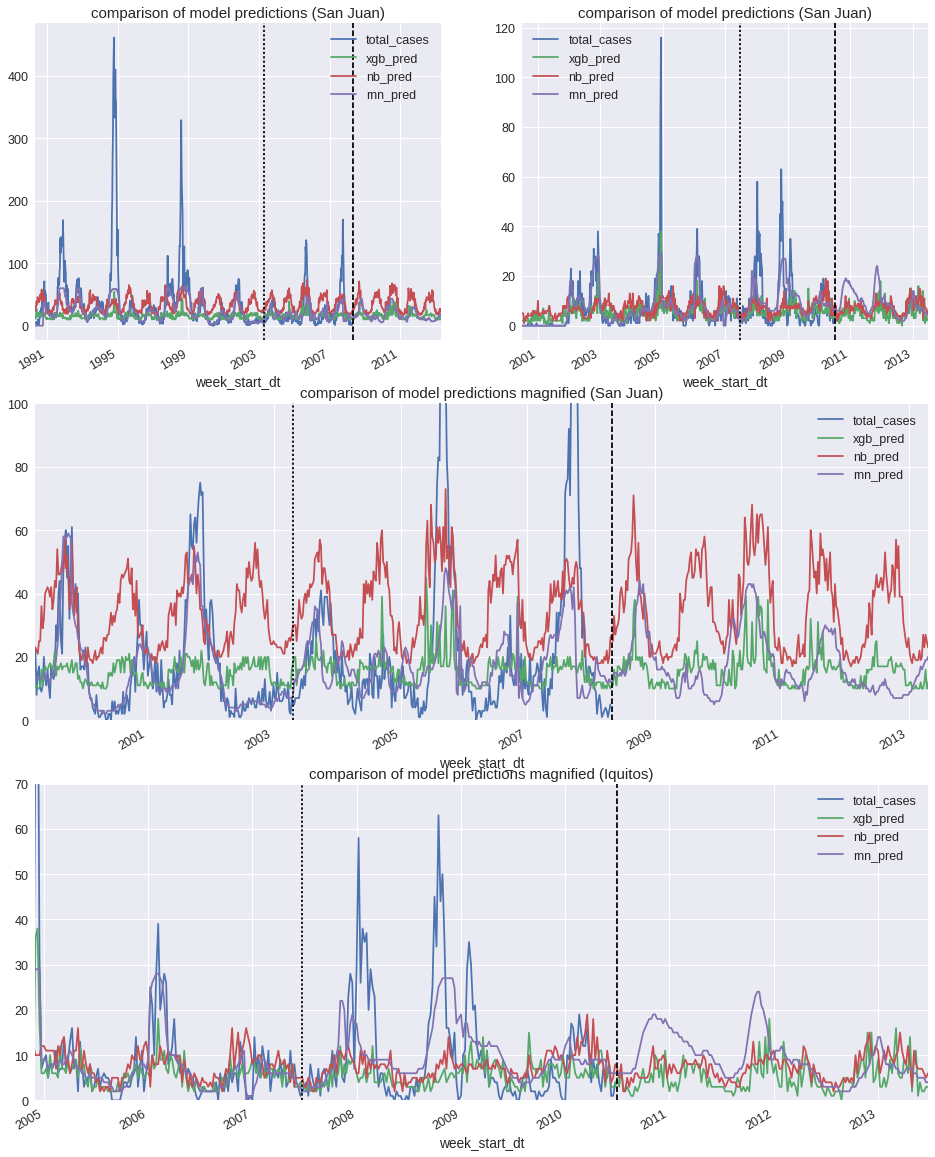

In [9]:
plt.figure(figsize=(16, 22))
ax = plt.subplot(3, 2, 1)
df_all_sj.plot(x=col_date, y="total_cases", ax=ax)
df_all_sj.plot(x=col_date, y="xgb_pred", ax=ax)
df_all_sj.plot(x=col_date, y="nb_pred", ax=ax)
df_all_sj.plot(x=col_date, y="rnn_pred", ax=ax)
ax.set_title("comparison of model predictions (San Juan)")
plt.axvline(x=sj_valid, linestyle=':', color='black')
plt.axvline(x=sj_test, linestyle='--', color='black')

ax = plt.subplot(3, 2, 2)
df_all_iq.plot(x=col_date, y="total_cases", ax=ax)
df_all_iq.plot(x=col_date, y="xgb_pred", ax=ax)
df_all_iq.plot(x=col_date, y="nb_pred", ax=ax)
df_all_iq.plot(x=col_date, y="rnn_pred", ax=ax)
ax.set_title("comparison of model predictions (San Juan)")
plt.axvline(x=iq_valid, linestyle=':', color='black')
plt.axvline(x=iq_test, linestyle='--', color='black')

#ax = plt.subplot((2, 2), (1, 0), colspan=2)
ax = plt.subplot2grid((3,2), (1,0), colspan=2)
df_all_sj.plot(x=col_date, y="total_cases", ax=ax)
df_all_sj.plot(x=col_date, y="xgb_pred", ax=ax)
df_all_sj.plot(x=col_date, y="nb_pred", ax=ax)
df_all_sj.plot(x=col_date, y="rnn_pred", ax=ax)
ax.set_title("comparison of model predictions magnified (San Juan)")
plt.axvline(x=sj_valid, linestyle=':', color='black')
plt.axvline(x=sj_test, linestyle='--', color='black')

ax.set_xlim("1999-4-1", "2013-04-23")
ax.set_ylim(0, 100)

ax = plt.subplot2grid((3,2), (2,0), colspan=2)
ax = df_all_iq.plot(x=col_date, y="total_cases", ax=ax)
df_all_iq.plot(x=col_date, y="xgb_pred", ax=ax)
df_all_iq.plot(x=col_date, y="nb_pred", ax=ax)
df_all_iq.plot(x=col_date, y="rnn_pred", ax=ax)
ax.set_title("comparison of model predictions magnified (Iquitos)")
plt.axvline(x=iq_valid, linestyle=':', color='black')
plt.axvline(x=iq_test, linestyle='--', color='black')

ax.set_xlim("2004-12-1", "2013-06-25")
ax.set_ylim(0, 70)

plt.savefig("./img/pred_comparison.svg", bbox_inches='tight')

In [10]:
xgb_test_pred_sj = xgb_utils.create_prediction(model_xgb_sj, ds_sj.df_test, col_feats_xgb_sj)
nb_test_pred_sj = glm_utils.create_prediction(model_nb_sj, ds_sj.df_test, col_feats_nb_sj)
rnn_test_pred_sj = rnn_utils.create_prediction(model_rnn_sj, ds_sj.df_test, col_feats_rnn_sj)

xgb_test_pred_iq = xgb_utils.create_prediction(model_xgb_iq, ds_iq.df_test, col_feats_xgb_iq)
nb_test_pred_iq = glm_utils.create_prediction(model_nb_iq, ds_iq.df_test, col_feats_nb_iq)
rnn_test_pred_iq = rnn_utils.create_prediction(model_rnn_iq, ds_iq.df_test, col_feats_rnn_iq)

In [11]:
sj_mae = mean_absolute_error(xgb_test_pred_sj, nb_test_pred_sj)
iq_mae = mean_absolute_error(xgb_test_pred_iq, nb_test_pred_iq)
print(sj_mae, iq_mae)

19.1769230769 2.78846153846


In [12]:
sj_mae = mean_absolute_error(rnn_test_pred_sj, nb_test_pred_sj)
iq_mae = mean_absolute_error(rnn_test_pred_iq, nb_test_pred_iq)
print(sj_mae, iq_mae)

18.3115384615 3.98717948718


(0, 150)

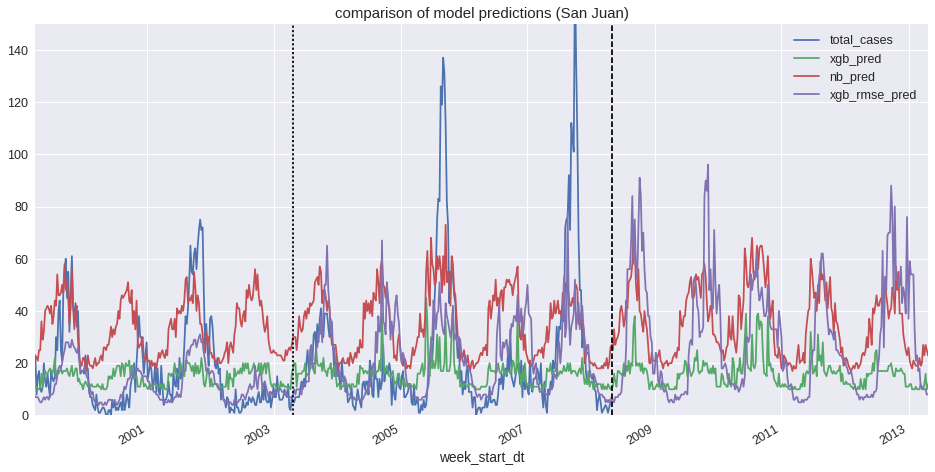

In [13]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
df_all_sj.plot(x=col_date, y="total_cases", ax=ax)
df_all_sj.plot(x=col_date, y="xgb_pred", ax=ax)
df_all_sj.plot(x=col_date, y="nb_pred", ax=ax)
df_all_sj.plot(x=col_date, y="xgb_rmse_pred", ax=ax)
ax.set_title("comparison of model predictions (San Juan)")
plt.axvline(x=sj_valid, linestyle=':', color='black')
plt.axvline(x=sj_test, linestyle='--', color='black')

ax.set_xlim("1999-4-1", "2013-04-23")
ax.set_ylim(0, 150)